In [1]:
# dl packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical



# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [2]:
train_data = pd.read_csv("data/train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [3]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [4]:
train_data.shape

(16000, 3)

In [5]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [6]:
train_data.duplicated().sum()

np.int64(1)

## EDA

In [7]:
train_data['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

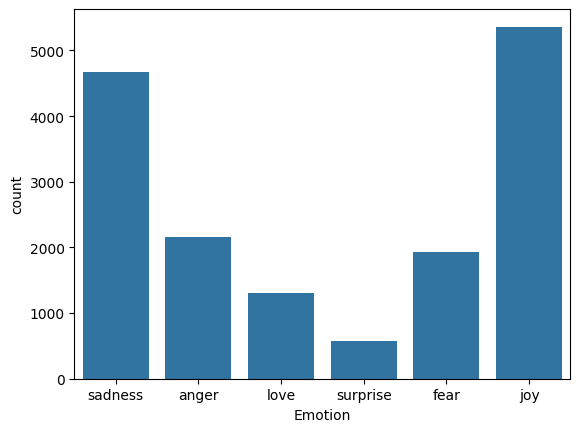

In [8]:
sns.countplot(x=train_data['Emotion'])
plt.show()

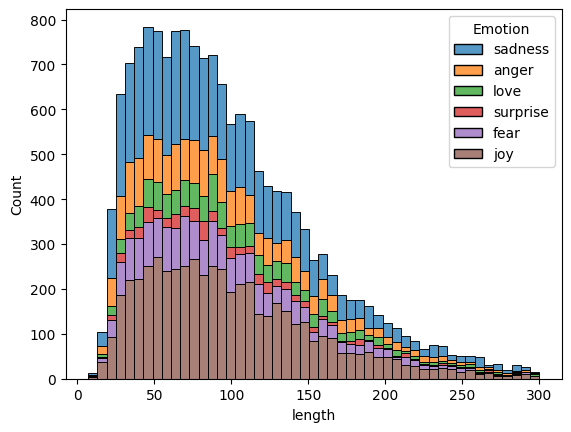

In [9]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

length_values = df2['length'].values

sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

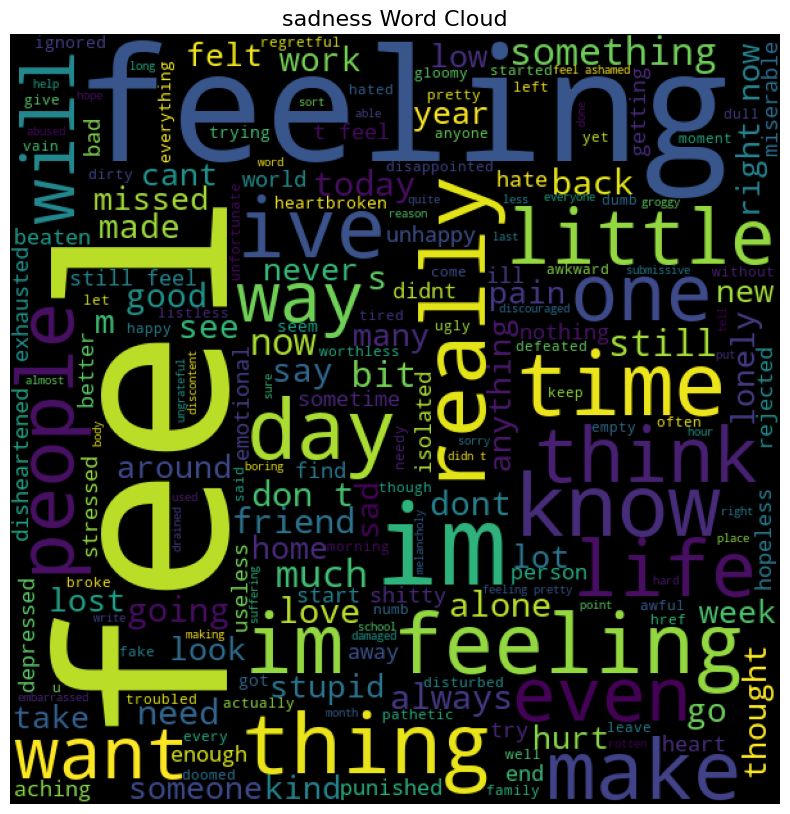

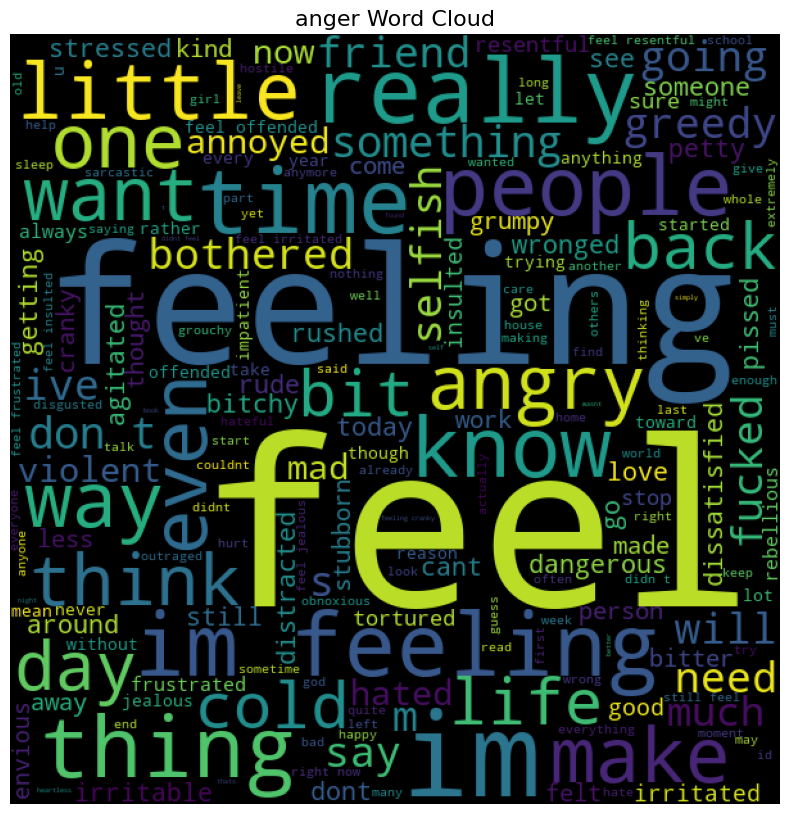

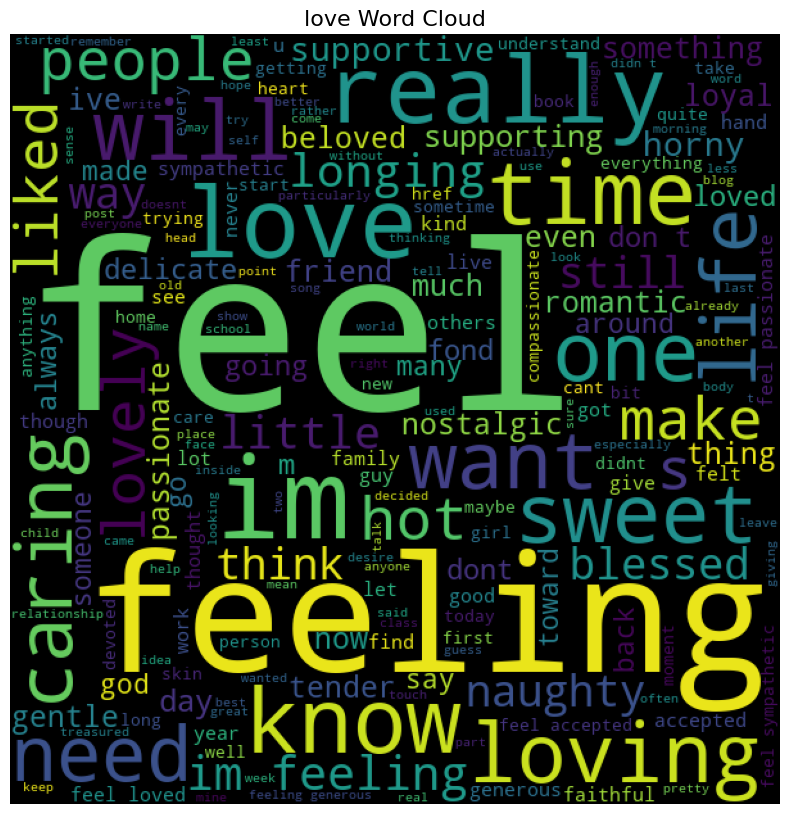

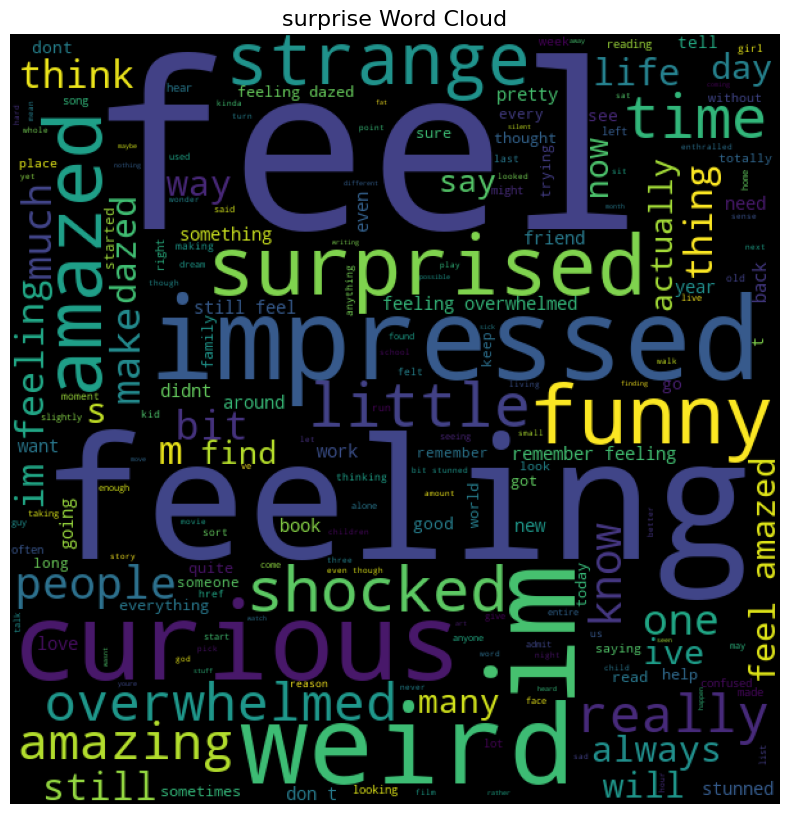

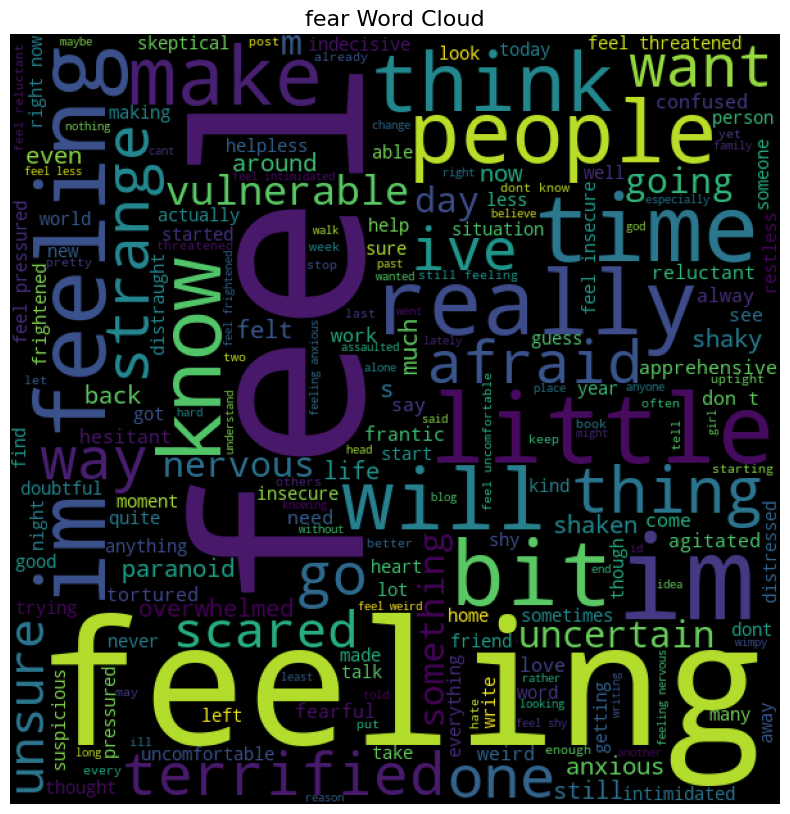

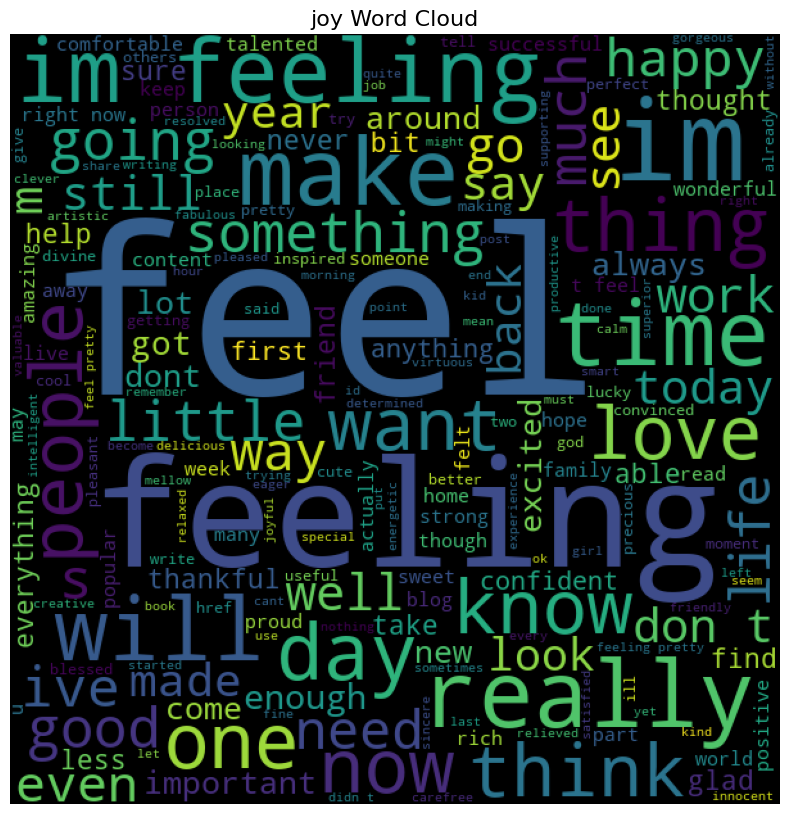

In [10]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

## Encode Emotions

In [11]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [12]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


## Applying Machine Learning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = train_data.copy()

In [15]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Data cleaning and preprocessing

In [16]:
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [18]:
df

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,4,102,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,2,30,feel strong good overal
15998,i feel like this was such a rude comment and i...,0,59,feel like rude comment im glad


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [34]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [35]:
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

In [37]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

In [38]:

for i in range(len(list(classifiers))):
    model = list(classifiers.values())[i]
    model_name = list(classifiers.keys())[i]
    model.fit(X_train_tfidf, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train, y_train_pred, average='weighted')

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test, y_test_pred, average='weighted')

    # Binarize labels for multiclass ROC AUC
    classes = list(set(y_train))  # Or use `np.unique(y_train)`
    y_train_bin = label_binarize(y_train, classes=classes)
    y_train_pred_bin = label_binarize(y_train_pred, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    y_test_pred_bin = label_binarize(y_test_pred, classes=classes)

    model_train_rocauc_score = roc_auc_score(y_train_bin, y_train_pred_bin, average='weighted', multi_class='ovr')
    model_test_rocauc_score = roc_auc_score(y_test_bin, y_test_pred_bin, average='weighted', multi_class='ovr')

    # Print results
    print(f"\n===== {model_name} =====")

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- ROC AUC Score: {:.4f}'.format(model_train_rocauc_score))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- ROC AUC Score: {:.4f}'.format(model_test_rocauc_score))

    print('=' * 35)


===== Multinomial Naive Bayes =====
Model performance for Training set
- Accuracy: 0.7372
- F1 score: 0.6880
- Precision: 0.8061
- Recall: 0.7372
- ROC AUC Score: 0.8067
----------------------------------
Model performance for Test set
- Accuracy: 0.6550
- F1 score: 0.5816
- Precision: 0.7578
- Recall: 0.6550
- ROC AUC Score: 0.7504

===== Logistic Regression =====
Model performance for Training set
- Accuracy: 0.9188
- F1 score: 0.9167
- Precision: 0.9204
- Recall: 0.9188
- ROC AUC Score: 0.9433
----------------------------------
Model performance for Test set
- Accuracy: 0.8294
- F1 score: 0.8220
- Precision: 0.8309
- Recall: 0.8294
- ROC AUC Score: 0.8839

===== Random Forest =====
Model performance for Training set
- Accuracy: 0.9978
- F1 score: 0.9978
- Precision: 0.9978
- Recall: 0.9978
- ROC AUC Score: 0.9987
----------------------------------
Model performance for Test set
- Accuracy: 0.8497
- F1 score: 0.8478
- Precision: 0.8497
- Recall: 0.8497
- ROC AUC Score: 0.9024

=====